In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

In [47]:

class CNN_default(nn.Module):
    def __init__(self, optimizer_type, learning_rate):
        super(CNN_default, self).__init__()
        self.optimizer_type = optimizer_type
        self.learning_rate = learning_rate
        self.loss_function = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return x
    
    def fit(self, train_loader, epochs):
        optimizer = self.optimizer_type(self.parameters(), lr=self.learning_rate)
        self.train()
        
        for images, labels in train_loader:
            # Прямой проход
            outputs = self(images)
            loss = self.loss_function(outputs, labels)
            
            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()
        
    def predict(self, test_loader):
        correct = 0
        total = 0
        
        self.eval()
        
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        
        return correct / total

    def evaluate(self, test_loader):
        total_loss = 0
        
        self.eval()
        
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self(images)
                loss = self.loss_function(outputs, labels)
                total_loss += loss.item()
        
        return total_loss / len(test_loader)

In [48]:

class LeNet(CNN_default):
    def __init__(self, optimizer, learning_rate):
        super(LeNet, self).__init__(optimizer, learning_rate)
        
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [77]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

MNIST_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
MNIST_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

MNIST_train_loader = DataLoader(MNIST_train_dataset, shuffle=True)
MNIST_test_loader = DataLoader(MNIST_test_dataset, shuffle=True)

print(f"Размер обучающего датасета: {len(MNIST_train_dataset)}")
print(f"Размер тестового датасета: {len(MNIST_test_dataset)}")

Размер обучающего датасета: 60000
Размер тестового датасета: 10000


In [67]:
LeNet_SGD_accuracies = []
LeNet_SGD_losses = []

LeNet_SGD_model = LeNet(optim.SGD, learning_rate=1e-6)
for _ in range(10):
    LeNet_SGD_model.fit(MNIST_train_dataset, epochs=1)
    LeNet_SGD_accuracies.append(LeNet_SGD_model.predict(MNIST_test_dataset))
    LeNet_SGD_losses.append(LeNet_SGD_model.evaluate(MNIST_test_dataset))
    print(LeNet_SGD_accuracies[-1], LeNet_SGD_losses[-1])

0.723 0.9020928097941113
0.855 0.8520079698949511
0.463 1.870106275057617
0.147 2.2289677484742283
0.087 2.3584985506534575
0.085 2.430478364944458
0.087 2.3360368545055388
0.126 2.4081402806043624
0.11 2.3334052774906158
0.126 2.41725488615036


In [69]:
LeNet_AdaDelta_accuracies = []
LeNet_AdaDelta_losses = []

LeNet_AdaDelta_model = LeNet(optim.Adadelta, learning_rate=1e-6)
for _ in range(10):
    LeNet_AdaDelta_model.fit(MNIST_train_dataset, epochs=1)
    LeNet_AdaDelta_accuracies.append(LeNet_AdaDelta_model.predict(MNIST_test_dataset))
    LeNet_AdaDelta_losses.append(LeNet_AdaDelta_model.evaluate(MNIST_test_dataset))
    print(LeNet_AdaDelta_accuracies[-1], LeNet_AdaDelta_losses[-1])

0.323 2.273204564332962
0.347 2.2638577575683594
0.363 2.257652475118637
0.37 2.251875804901123
0.385 2.2458798847198485
0.396 2.2396984984874724
0.392 2.2331762425899506
0.397 2.2263344330787658
0.404 2.2191371284723282
0.412 2.2114676594734193


In [70]:
LeNet_NAG_accuracies = []
LeNet_NAG_losses = []

LeNet_NAG_model = LeNet(lambda params, lr: optim.SGD(params, lr=lr, momentum=.9, nesterov=True), learning_rate=1e-6)
for _ in range(10):
    LeNet_NAG_model.fit(MNIST_train_dataset, epochs=1)
    LeNet_NAG_accuracies.append(LeNet_NAG_model.predict(MNIST_test_dataset))
    LeNet_NAG_losses.append(LeNet_NAG_model.evaluate(MNIST_test_dataset))
    print(LeNet_NAG_accuracies[-1], LeNet_NAG_losses[-1])

0.2 2.736087410183215
0.126 2.5347468856573103
0.11 2.6953072971105576
0.126 2.62238682281971
0.094 2.635318238735199
0.087 2.5632050887346267
0.11 2.7262517547607423
0.085 2.857922829866409
0.089 2.703109181523323
0.085 2.9964538980722426


In [71]:
LeNet_Adam_accuracies = []
LeNet_Adam_losses = []

LeNet_Adam_model = LeNet(optim.Adam, learning_rate=1e-6)
for _ in range(10):
    LeNet_Adam_model.fit(MNIST_train_dataset, epochs=1)
    LeNet_Adam_accuracies.append(LeNet_Adam_model.predict(MNIST_test_dataset))
    LeNet_Adam_losses.append(LeNet_Adam_model.evaluate(MNIST_test_dataset))
    print(LeNet_Adam_accuracies[-1], LeNet_Adam_losses[-1])

0.546 1.628600043952465
0.764 0.7384602129139239
0.819 0.6836352683667113
0.84 0.7429248831801416
0.858 0.5799305071917685
0.882 0.3837404256450954
0.9 0.29377000624600696
0.914 0.2641157044524741
0.932 0.20987969920035102
0.938 0.17220884699044162


In [72]:
epoch_list = list(range(10))

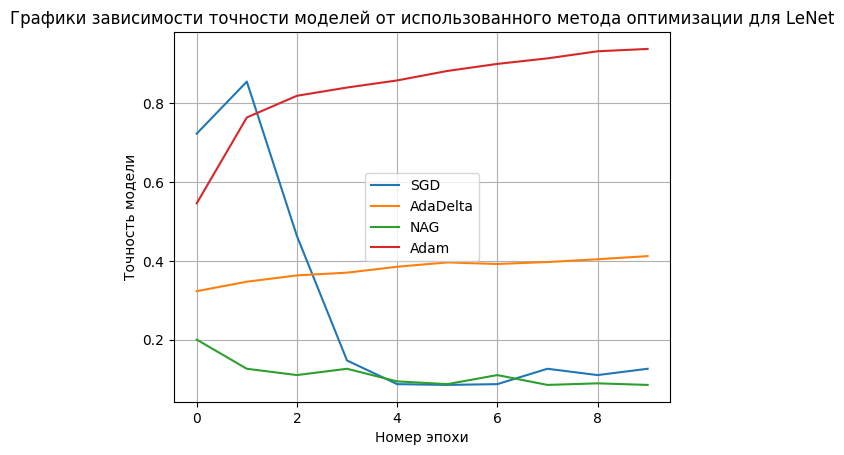

In [79]:
plt.plot(epoch_list, LeNet_SGD_accuracies, label="SGD")
plt.plot(epoch_list, LeNet_AdaDelta_accuracies, label="AdaDelta")
plt.plot(epoch_list, LeNet_NAG_accuracies, label="NAG")
plt.plot(epoch_list, LeNet_Adam_accuracies, label="Adam")

plt.title("Графики зависимости точности моделей от использованного метода оптимизации для LeNet")
plt.xlabel("Номер эпохи")
plt.ylabel("Точность модели")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
plt.plot(epoch_list, LeNet_SGD_losses, label="SGD")
plt.plot(epoch_list, LeNet_AdaDelta_losses, label="AdaDelta")
plt.plot(epoch_list, LeNet_NAG_losses, label="NAG")
plt.plot(epoch_list, LeNet_Adam_losses, label="Adam")

plt.title("Графики зависимости функции потерь моделей от использованного метода оптимизации для LeNet")
plt.xlabel("Номер эпохи")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()

In [97]:
class VGG16(CNN_default):
    def __init__(self, optimizer, learning_rate):
        super(VGG16, self).__init__(optimizer, learning_rate)
        
        self.conv1_1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv3_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(512 * 3 * 3, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

In [99]:

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

CIFAR10_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
CIFAR10_test_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)

CIFAR10_train_dataset = Subset(CIFAR10_train_dataset, indices=list(range(1000)))
CIFAR10_test_dataset = Subset(CIFAR10_test_dataset, indices=list(range(100)))

CIFAR10_train_loader = DataLoader(CIFAR10_train_dataset, shuffle=True, num_workers=2)
CIFAR10_test_loader = DataLoader(CIFAR10_test_dataset, shuffle=True, num_workers=2)

print(f"Размер обучающего набора: {len(CIFAR10_train_dataset)}")
print(f"Размер тестового набора: {len(CIFAR10_test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Размер обучающего набора: 1000
Размер тестового набора: 100


In [100]:
VGG16_SGD_accuracies = []
VGG16_SGD_losses = []

VGG16_SGD_model = VGG16(optim.SGD, learning_rate=1e-6)
for _ in range(10):
    VGG16_SGD_model.fit(CIFAR10_train_loader, epochs=1)
    VGG16_SGD_accuracies.append(VGG16_SGD_model.predict(CIFAR10_test_loader))
    VGG16_SGD_losses.append(VGG16_SGD_model.evaluate(CIFAR10_test_loader))
    print(VGG16_SGD_accuracies[-1], VGG16_SGD_losses[-1])

0.16 2.3004825782775877
0.16 2.299757821559906
0.16 2.2984605193138123
0.16 2.2982958364486694
0.16 2.297400939464569
0.16 2.2976022696495058
0.16 2.296946017742157
0.16 2.2959431314468386
0.16 2.293362867832184
0.16 2.2883520483970643


In [101]:
VGG16_AdaDelta_accuracies = []
VGG16_AdaDelta_losses = []

VGG16_AdaDelta_model = VGG16(optim.Adadelta, learning_rate=1e-6)
for _ in range(10):
    VGG16_AdaDelta_model.fit(CIFAR10_train_loader, epochs=1)
    VGG16_AdaDelta_accuracies.append(VGG16_AdaDelta_model.predict(CIFAR10_test_loader))
    VGG16_AdaDelta_losses.append(VGG16_AdaDelta_model.evaluate(CIFAR10_test_loader))
    print(VGG16_AdaDelta_accuracies[-1], VGG16_AdaDelta_losses[-1])

0.07 2.3000015592575074
0.07 2.2998848581314086
0.07 2.29977707862854
0.07 2.299650418758392


In [ ]:
VGG16_NAG_accuracies = []
VGG16_NAG_losses = []

VGG16_NAG_model = VGG16(lambda params, lr: optim.SGD(params, lr=lr, momentum=.9, nesterov=True), learning_rate=1e-6)
for _ in range(10):
    VGG16_NAG_model.fit(CIFAR10_train_loader, epochs=1)
    VGG16_NAG_accuracies.append(VGG16_NAG_model.predict(CIFAR10_test_loader))
    VGG16_NAG_losses.append(VGG16_NAG_model.evaluate(CIFAR10_test_loader))
    print(VGG16_NAG_accuracies[-1], VGG16_NAG_losses[-1])

In [ ]:
VGG16_Adam_accuracies = []
VGG16_Adam_losses = []

VGG16_Adam_model = VGG16(optim.Adam, learning_rate=1e-6)
for _ in range(10):
    VGG16_Adam_model.fit(CIFAR10_train_loader, epochs=1)
    VGG16_Adam_accuracies.append(VGG16_Adam_model.predict(CIFAR10_test_loader))
    VGG16_Adam_losses.append(VGG16_Adam_model.evaluate(CIFAR10_test_loader))
    print(VGG16_Adam_accuracies[-1], VGG16_Adam_losses[-1])

In [ ]:
plt.plot(epoch_list, VGG16_SGD_accuracies, label="SGD")
plt.plot(epoch_list, VGG16_AdaDelta_accuracies, label="AdaDelta")
plt.plot(epoch_list, VGG16_NAG_accuracies, label="NAG")
plt.plot(epoch_list, VGG16_Adam_accuracies, label="Adam")

plt.title("Графики зависимости точности моделей от использованного метода оптимизации для VGG16")
plt.xlabel("Номер эпохи")
plt.ylabel("Точность модели")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
class BasicBlock(CNN_default):
    expansion = 1

    def __init__(self, optimizer, learning_rate):
        super(BasicBlock, self).__init__(optimizer, learning_rate)
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet34(CNN_default):
    def __init__(self, optimizer, learning_rate, num_classes=1000):
        super(ResNet34, self).__init__(optimizer, learning_rate)
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 64, 3, stride=1)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 6, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x